In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
from pathlib import Path
from matplotlib import pyplot as plt

from robustpca.general import DATADIR


In [3]:
frame_paths = sorted(list(Path(DATADIR, 'mall_dataset/frames').glob('*.jpg')))[::40]
frames = list(map(lambda path: cv2.imread(path.as_posix()).mean(-1), frame_paths))
small_frames = list(map(lambda frame: cv2.resize(frame, None, fx=0.4, fy=0.4), frames))

In [4]:
len(small_frames)

50

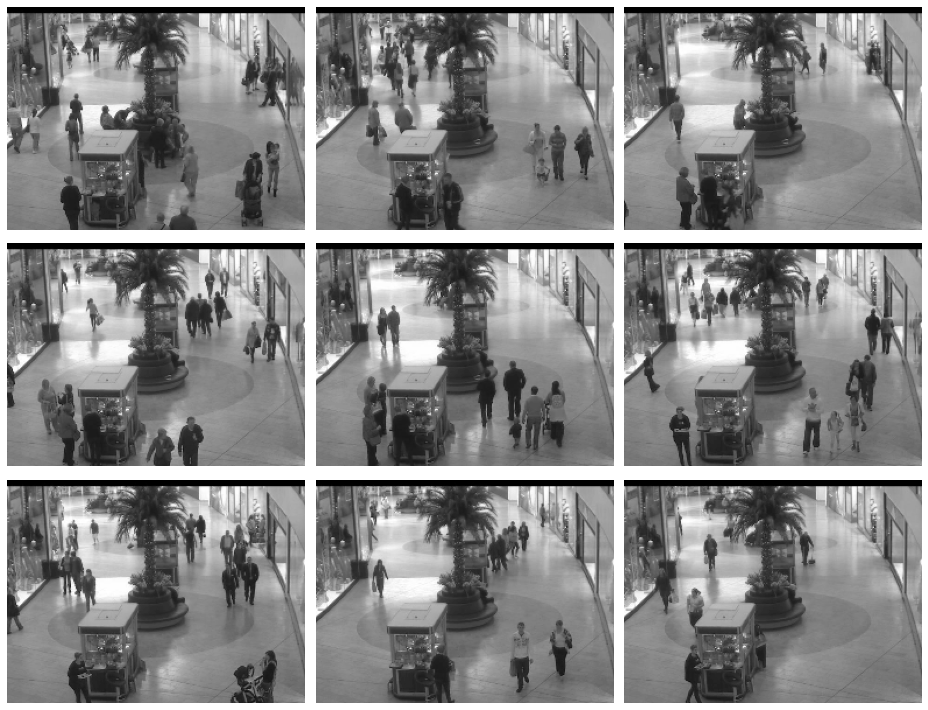

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(13, 10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(small_frames[i], cmap="gray")
    ax.axis("off")

fig.tight_layout()

In [6]:
data_mat = np.stack(small_frames, -1).reshape(-1, len(small_frames))
data_mat.shape

(49152, 50)

In [7]:
from robustpca.pcp import PCP
from robustpca.pcp import StablePCP

In [8]:
pcp_alm = PCP()
mu = pcp_alm.default_mu(data_mat)
L_pcp, S_pcp = pcp_alm.decompose(data_mat, mu, tol=1e-5, max_iter=500)

Elapsed: 84.22


In [9]:
f'intrisic rank: {np.linalg.matrix_rank(L_pcp)}, original rank: {np.linalg.matrix_rank(data_mat)}, fraction of outliers: {(S_pcp != 0).mean():.3f}'

'intrisic rank: 24, original rank: 50, fraction of outliers: 0.842'

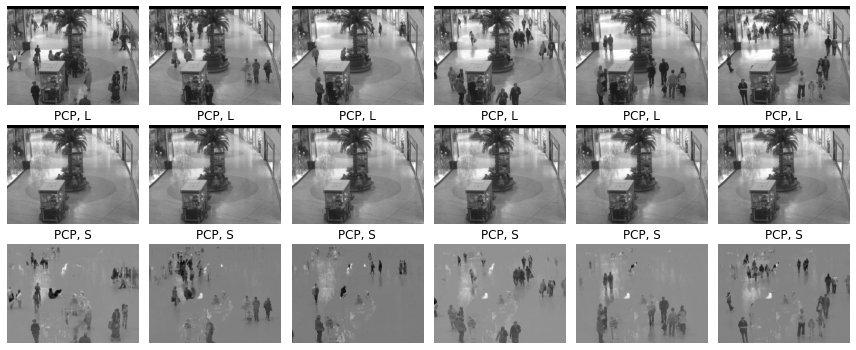

In [12]:
from matplotlib import pyplot as plt

ncols = 6
fig, axs = plt.subplots(3, ncols, figsize=(12, 5))

for ax in axs.flatten():
    ax.axis('off')

for i in range(ncols):
    background = L_pcp[:, i].reshape(small_frames[i].shape)
    foreground = S_pcp[:, i].reshape(small_frames[i].shape)
    axs[0, i].imshow(small_frames[i], cmap='gray')

    axs[1, i].imshow(background, cmap='gray')
    axs[1, i].set_title("PCP, L")

    axs[2, i].imshow(foreground, cmap='gray')
    axs[2, i].set_title("PCP, S")

fig.tight_layout()
plt.savefig("../figs/pcp_mall.pdf")

In [13]:
st_pcp = StablePCP()
mu = st_pcp.default_mu(data_mat, sigma=10)
L_st_pcp, S_st_pcp = st_pcp.decompose(data_mat, mu, tol=1e-5, max_iter=500)

Elapsed: 166.99


In [14]:
f'intrisic rank: {np.linalg.matrix_rank(L_st_pcp)}, original rank: {np.linalg.matrix_rank(data_mat)}, fraction of outliers: {(S_st_pcp != 0).mean():.3f}'

'intrisic rank: 2, original rank: 50, fraction of outliers: 0.177'

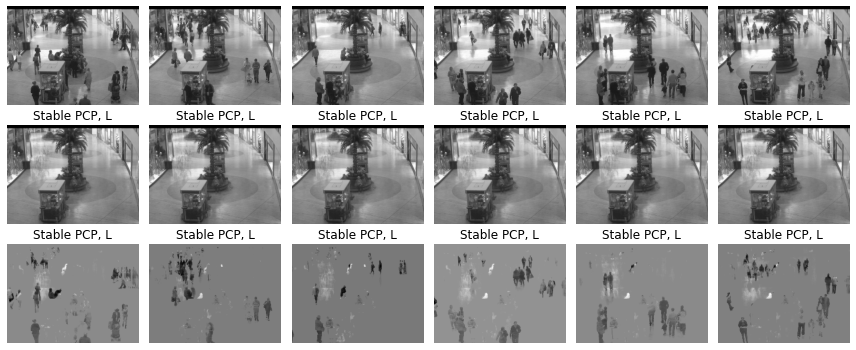

In [30]:
from matplotlib import pyplot as plt

ncols = 6
fig, axs = plt.subplots(3, ncols, figsize=(12, 5))

for ax in axs.flatten():
    ax.axis('off')

for i in range(ncols):
    axs[0, i].imshow(small_frames[i], cmap='gray')

    # background = L_pcp[:, i].reshape(small_frames[i].shape)
    # foreground = S_pcp[:, i].reshape(small_frames[i].shape)
    # axs[1, i].imshow(background, cmap='gray')
    # axs[1, i].set_title("PCP, L")
    # axs[2, i].imshow(foreground, cmap='gray')
    # axs[2, i].set_title("PCP, S")

    background = L_st_pcp[:, i].reshape(small_frames[i].shape)
    foreground = S_st_pcp[:, i].reshape(small_frames[i].shape)
    axs[1, i].imshow(background, cmap='gray')
    axs[1, i].set_title("Stable PCP, L")
    axs[2, i].imshow(foreground, cmap='gray')
    axs[2, i].set_title("Stable PCP, L")

fig.tight_layout()
plt.savefig("../figs/stable_pcp_mall.pdf")

In [20]:
from robustpca.ircur import IRCUR

In [21]:
pcp_alm = IRCUR()
rank = 2
c = 4
nrows, ncols = int(c * rank * np.log(data_mat.shape[0])), int(c * rank * np.log(data_mat.shape[1]))
L_ircur, S_ircur = pcp_alm.decompose(data_mat, rank, nrows, ncols, thresholding_decay=0.65, initial_threshold=100, verbose=True, max_iter=500, tol=1e-9)

Iteration: 49, diff: 7.593746822907945e-10, terminating alg.
Elapsed: 27.18


In [22]:
f'intrisic rank: {np.linalg.matrix_rank(L_ircur)}, original rank: {np.linalg.matrix_rank(data_mat)}, fraction of outliers: {(S_ircur != 0).mean():.3f}'

'intrisic rank: 2, original rank: 50, fraction of outliers: 0.976'

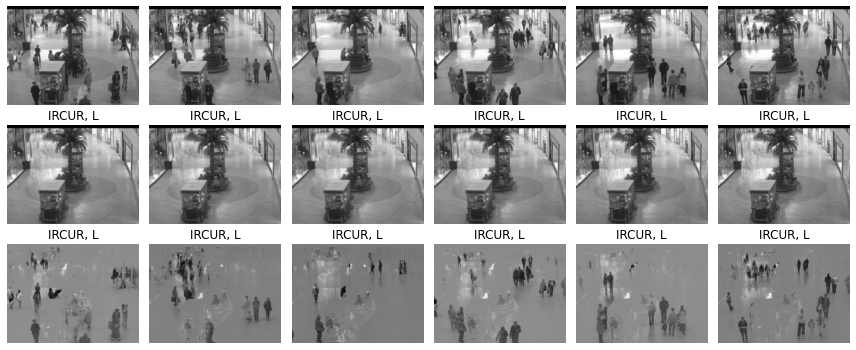

In [29]:
from matplotlib import pyplot as plt

ncols = 6
fig, axs = plt.subplots(3, ncols, figsize=(12, 5))

for ax in axs.flatten():
    ax.axis('off')

for i in range(ncols):
    axs[0, i].imshow(small_frames[i], cmap='gray')

    # background = L_pcp[:, i].reshape(small_frames[i].shape)
    # foreground = S_pcp[:, i].reshape(small_frames[i].shape)
    # axs[1, i].imshow(background, cmap='gray')
    # axs[1, i].set_title("PCP, L")
    # axs[2, i].imshow(foreground, cmap='gray')
    # axs[1, i].set_title("PCP, S")

    # background = L_st_pcp[:, i].reshape(small_frames[i].shape)
    # foreground = S_st_pcp[:, i].reshape(small_frames[i].shape)
    # axs[3, i].imshow(background, cmap='gray')
    # axs[3, i].set_title("Stable PCP, L")
    # axs[4, i].imshow(foreground, cmap='gray')
    # axs[4, i].set_title("Stable PCP, S")

    background = L_ircur[:, i].reshape(small_frames[i].shape)
    foreground = S_ircur[:, i].reshape(small_frames[i].shape)
    axs[1, i].imshow(background, cmap='gray')
    axs[1, i].set_title("IRCUR, L")
    axs[2, i].imshow(foreground, cmap='gray')
    axs[2, i].set_title("IRCUR, L")

fig.tight_layout()
plt.savefig("../figs/ircur_mall.pdf")